# Explore Case 2 - Schwarzschild Results

## import utils

In [1]:
project_path = "../../../../../"
utils_path = project_path * "src/utils/"

data_path = project_path * "data/input/case_2/";
output_directory = project_path * "data/output/case_2/schwarzschild/";

In [2]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();

using OrdinaryDiffEq;
using Optim;
using DiffEqSensitivity;
using Plots;
using Flux;


import Statistics: mean, sqrt
import CSV: CSV
import DataFrames: DataFrame, select, filter
import DiffEqFlux: sciml_train
import Random: seed!
import LineSearches: BackTracking
import DelimitedFiles: readdlm
import BSON: @save, @load
# gr(); # specify backend for plotting


  Activating project at `~/Escritorio/TFM/code/01_project`


In [3]:

include(utils_path * "utils.jl")
import_project_utils(utils_path);

In [4]:
# specify random seed
seed = 1234;
seed!(seed)

# script conditions
show_plots = false
save_plots_gif = false
save_data = true

# paths
test_name = "test_1_cos/"
model_name = "test_1_cos/"

output_dir = output_directory* "models/" * test_name
solutions_dir = output_dir * "solutions/"
predictions_dir = output_dir * "predictions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/"
list_directories = (output_dir, solutions_dir, metrics_dir, img_dir)
create_directories(list_directories)

## Dataset

In [5]:
# time range
datasize = 1500
dt = 10.0

# Load SXS Dataset
wave_ids = [
    "SXS:BBH:0211",
    "SXS:BBH:0217"
]

println("Load SXS Dataset")
dataset = load_sxs_data(wave_ids, data_path);

Load SXS Dataset
Importing data: SXS:BBH:0211
Importing data: SXS:BBH:0217


## Load NN Model

In [6]:
println("Defining model")
n_neurons = 32
nn_output = nn_model_case2(model_name, n_neurons, tanh)
_, _, _, _, _, chain_chiphi, chain_pe, _, _ = nn_output

# load saved models
@load solutions_dir*"model_chiphi.bson" chain_phichi
@load solutions_dir*"model_pe.bson" chain_pe

# restructure chains
NN_phichi_params, re_chiphi = Flux.destructure(chain_phichi)
NN_phichi(u, NN_phichi_params) = re_chiphi(NN_phichi_params)(u)
NN_pe_params, re_pe = Flux.destructure(chain_pe)
NN_pe(u, NN_pe_params) = re_pe(NN_pe_params)(u);

global NN_params
NN_params = vcat(NN_phichi_params,NN_pe_params)
l1 = length(NN_phichi_params);

Defining model


In [7]:
dataset = add_neural_network_problem_to_dataset(dataset, nn_output);

In [8]:
dataset_train = Dict([key => value for (key, value) in dataset if key != wave_ids[end]]);
dataset_test = Dict([key => value for (key, value) in dataset if key == wave_ids[end]]);

## Get predictions

In [9]:
# save predictions
processed_data = Dict("train" => dataset_train, "test" => dataset_test)
predictions = Dict("train" => [], "test" => [])

for (set, set_data) in processed_data

    for (wave_id, wave) in set_data

        println("Obtaining predictions for: ", set, " : ", wave["wave_id"])

        solution_nn = Array(
            solve(wave["nn_problem"], RK4(), u0 = wave["u0"], 
            p = NN_params, saveat = wave["tsteps"], 
            dt = wave["dt_data"], adaptive=false
        ))

        predictions_wave_i = Dict()

        predictions_wave_i["tsteps"] = wave["tsteps"]
        predictions_wave_i["true_waveform"] = wave["true_waveform"]
        predictions_wave_i["pred_waveform"], _ = compute_waveform(wave["dt_data"], solution_nn, wave["q"], wave["M"], wave["model_params"])
        predictions_wave_i["pred_solution"] = solution_nn
        # predictions_wave_i["true_solution"] = wave["true_solution"]

        pred_orbit = soln2orbit(solution_nn, wave["M"], wave["model_params"])
        pred_orbit_1, pred_orbit_2 = one2two(pred_orbit, wave["mass1"], wave["mass2"])
        predictions_wave_i["pred_orbit_1"] = pred_orbit_1
        predictions_wave_i["pred_orbit_2"] = pred_orbit_2

        # true_orbit = soln2orbit(wave["true_solution"], wave["M"], wave["model_params"])
        # true_orbit_1, true_orbit_2 = one2two(true_orbit, wave["mass1"], wave["mass2"])
        # predictions_wave_i["true_orbit_1"] = true_orbit_1
        # predictions_wave_i["true_orbit_2"] = true_orbit_2

        predictions_wave_i["true_orbit_x1"] = wave["true_orbit_x1"]
        predictions_wave_i["true_orbit_y1"] = wave["true_orbit_y1"]
        predictions_wave_i["true_orbit_x2"] = wave["true_orbit_x2"]
        predictions_wave_i["true_orbit_y2"] = wave["true_orbit_y2"]

        push!(predictions[set], predictions_wave_i)

    end

end


Obtaining predictions for: test : SXS:BBH:0217
Obtaining predictions for: train : SXS:BBH:0211


## Save predictions

In [10]:
# NOTE: this can be easily convert into a function and iterate over systems to save info

set = "train" # "test"
wave_index = 1 #

waveform_results_to_save = predictions[set][wave_index]

orbits = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_orbit_x1" => waveform_results_to_save["pred_orbit_1"][1, :],
    "pred_orbit_y1" => waveform_results_to_save["pred_orbit_1"][2, :],
    "true_orbit_x1" => waveform_results_to_save["true_orbit_x1"],
    "true_orbit_y1" => waveform_results_to_save["true_orbit_y1"],
    "pred_orbit_x2" => waveform_results_to_save["pred_orbit_2"][1, :],
    "pred_orbit_y2" => waveform_results_to_save["pred_orbit_2"][2, :],
    "true_orbit_x2" => waveform_results_to_save["true_orbit_x2"],
    "true_orbit_y2" => waveform_results_to_save["true_orbit_y2"],

)

equation_of_motion = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_solution_chi" => waveform_results_to_save["pred_solution"][1, :],
    "pred_solution_phi" => waveform_results_to_save["pred_solution"][2, :],
    "pred_solution_p" => waveform_results_to_save["pred_solution"][3, :],
    "pred_solution_e" => waveform_results_to_save["pred_solution"][4, :],
    # "true_solution_chi" => waveform_results_to_save["true_solution"][1, :],
    # "true_solution_phi" => waveform_results_to_save["true_solution"][2, :],
    # "true_solution_p" => waveform_results_to_save["true_solution"][3, :],
    # "true_solution_e" => waveform_results_to_save["true_solution"][4, :]
)

waveforms = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_waveform" => waveform_results_to_save["pred_waveform"],
    "true_waveform" => waveform_results_to_save["true_waveform"]
)


CSV.write(predictions_dir*"waveforms.csv", waveforms)
CSV.write(predictions_dir*"equation_of_motion.csv", equation_of_motion)
CSV.write(predictions_dir*"orbits.csv", orbits);

## Plots

In [11]:

plot_list = [];

for (set, set_data) in predictions

    for wave in set_data

        # waveforms
        x1 = plot(
            wave["tsteps"], 
            wave["true_waveform"],
            label="wform data (Re)", 
            # title="Waveforms",
            titlefontsize = 24,
            legendfontsize = legend_font_size,
            guidefontsize=title_font_size,
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            tickfontsize=tick_font_size,
            color=:black,
            seriestype=:scatter,
            ms=5,
            markershape=:none,
            size=(1200, 450),
            # bottom_margin = 10Plots.mm,
            left_margin = 25Plots.mm,
            right_margin = 10Plots.mm,
            # top_margin = 10Plots.mm,
            framestyle=:box,
            legend=:top, 
            legend_column=2,
            xlabel="Time",
            ylabel="Waveform"
            )
        plot!(
            x1, 
            wave["tsteps"], 
            wave["pred_waveform"],
            linewidth = line_width, label="wform NN (Re)"
        )

        # orbits
        x2 = plot(
            wave["pred_orbit_1"][1, :], wave["pred_orbit_1"][2, :],
            label="data", 
            # title=set_title(index),
            aspect_ratio=:equal,
            titlefontsize = title_font_size,
            legendfontsize = legend_font_size,
            guidefontsize=title_font_size,
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            tickfontsize=tick_font_size,
            markershape=:none,
            color=:black,
            # bottom_margin = 10Plots.mm,
            left_margin = 20Plots.mm,
            right_margin = 10Plots.mm,
            # top_margin = 5Plots.mm,
            framestyle=:box,
            # legend=:outertop,
            # legend_column=2,
            linewidth=line_width,
            xlabel="x",
            ylabel="y"
            )
        plot!(x2, wave["pred_orbit_2"][1, :], wave["pred_orbit_2"][2, :],
            linewidth=line_width,
            label="NN", 
            # title= ""*wave_id_dict[index], 
            linestyle=:dash
            )

        # p, e
        p = wave["pred_solution"][3, :]
        e = wave["pred_solution"][4, :]
        x3 = plot(
            wave["tsteps"], p, 
            label="semi-latus rectum",
            #  title=set_title(index),
            titlefontsize = title_font_size,
            legendfontsize = legend_font_size,
            guidefontsize=title_font_size,
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            tickfontsize=tick_font_size,
            markershape=:none,
            # bottom_margin = 10Plots.mm,
            left_margin = 10Plots.mm,
            right_margin = 10Plots.mm,
            # top_margin = 10Plots.mm,
            framestyle=:box,
            legend=:best,
            linewidth=line_width,
            xlabel="Tiempo"
        )
        plot!(twinx(), wave["tsteps"], e, linewidth = line_width, color=2, label="excentricidad",
        titlefontsize = title_font_size,
        legendfontsize = legend_font_size,
        guidefontsize=title_font_size,
        gridalpha=grid_alpha,
        gridstyle=grid_style,
        tickfontsize=tick_font_size,
        framstyle=:box,
        legend=:left
        )

        l = @layout [[a{0.4w} b]; c{0.6h}]
        x = plot(x3, x2, x1, layout=l)
        push!(plot_list, x)
    end
end

l = @layout [grid(2,1)]
plt = plot(plot_list..., layout=l, size=(2000,3000));


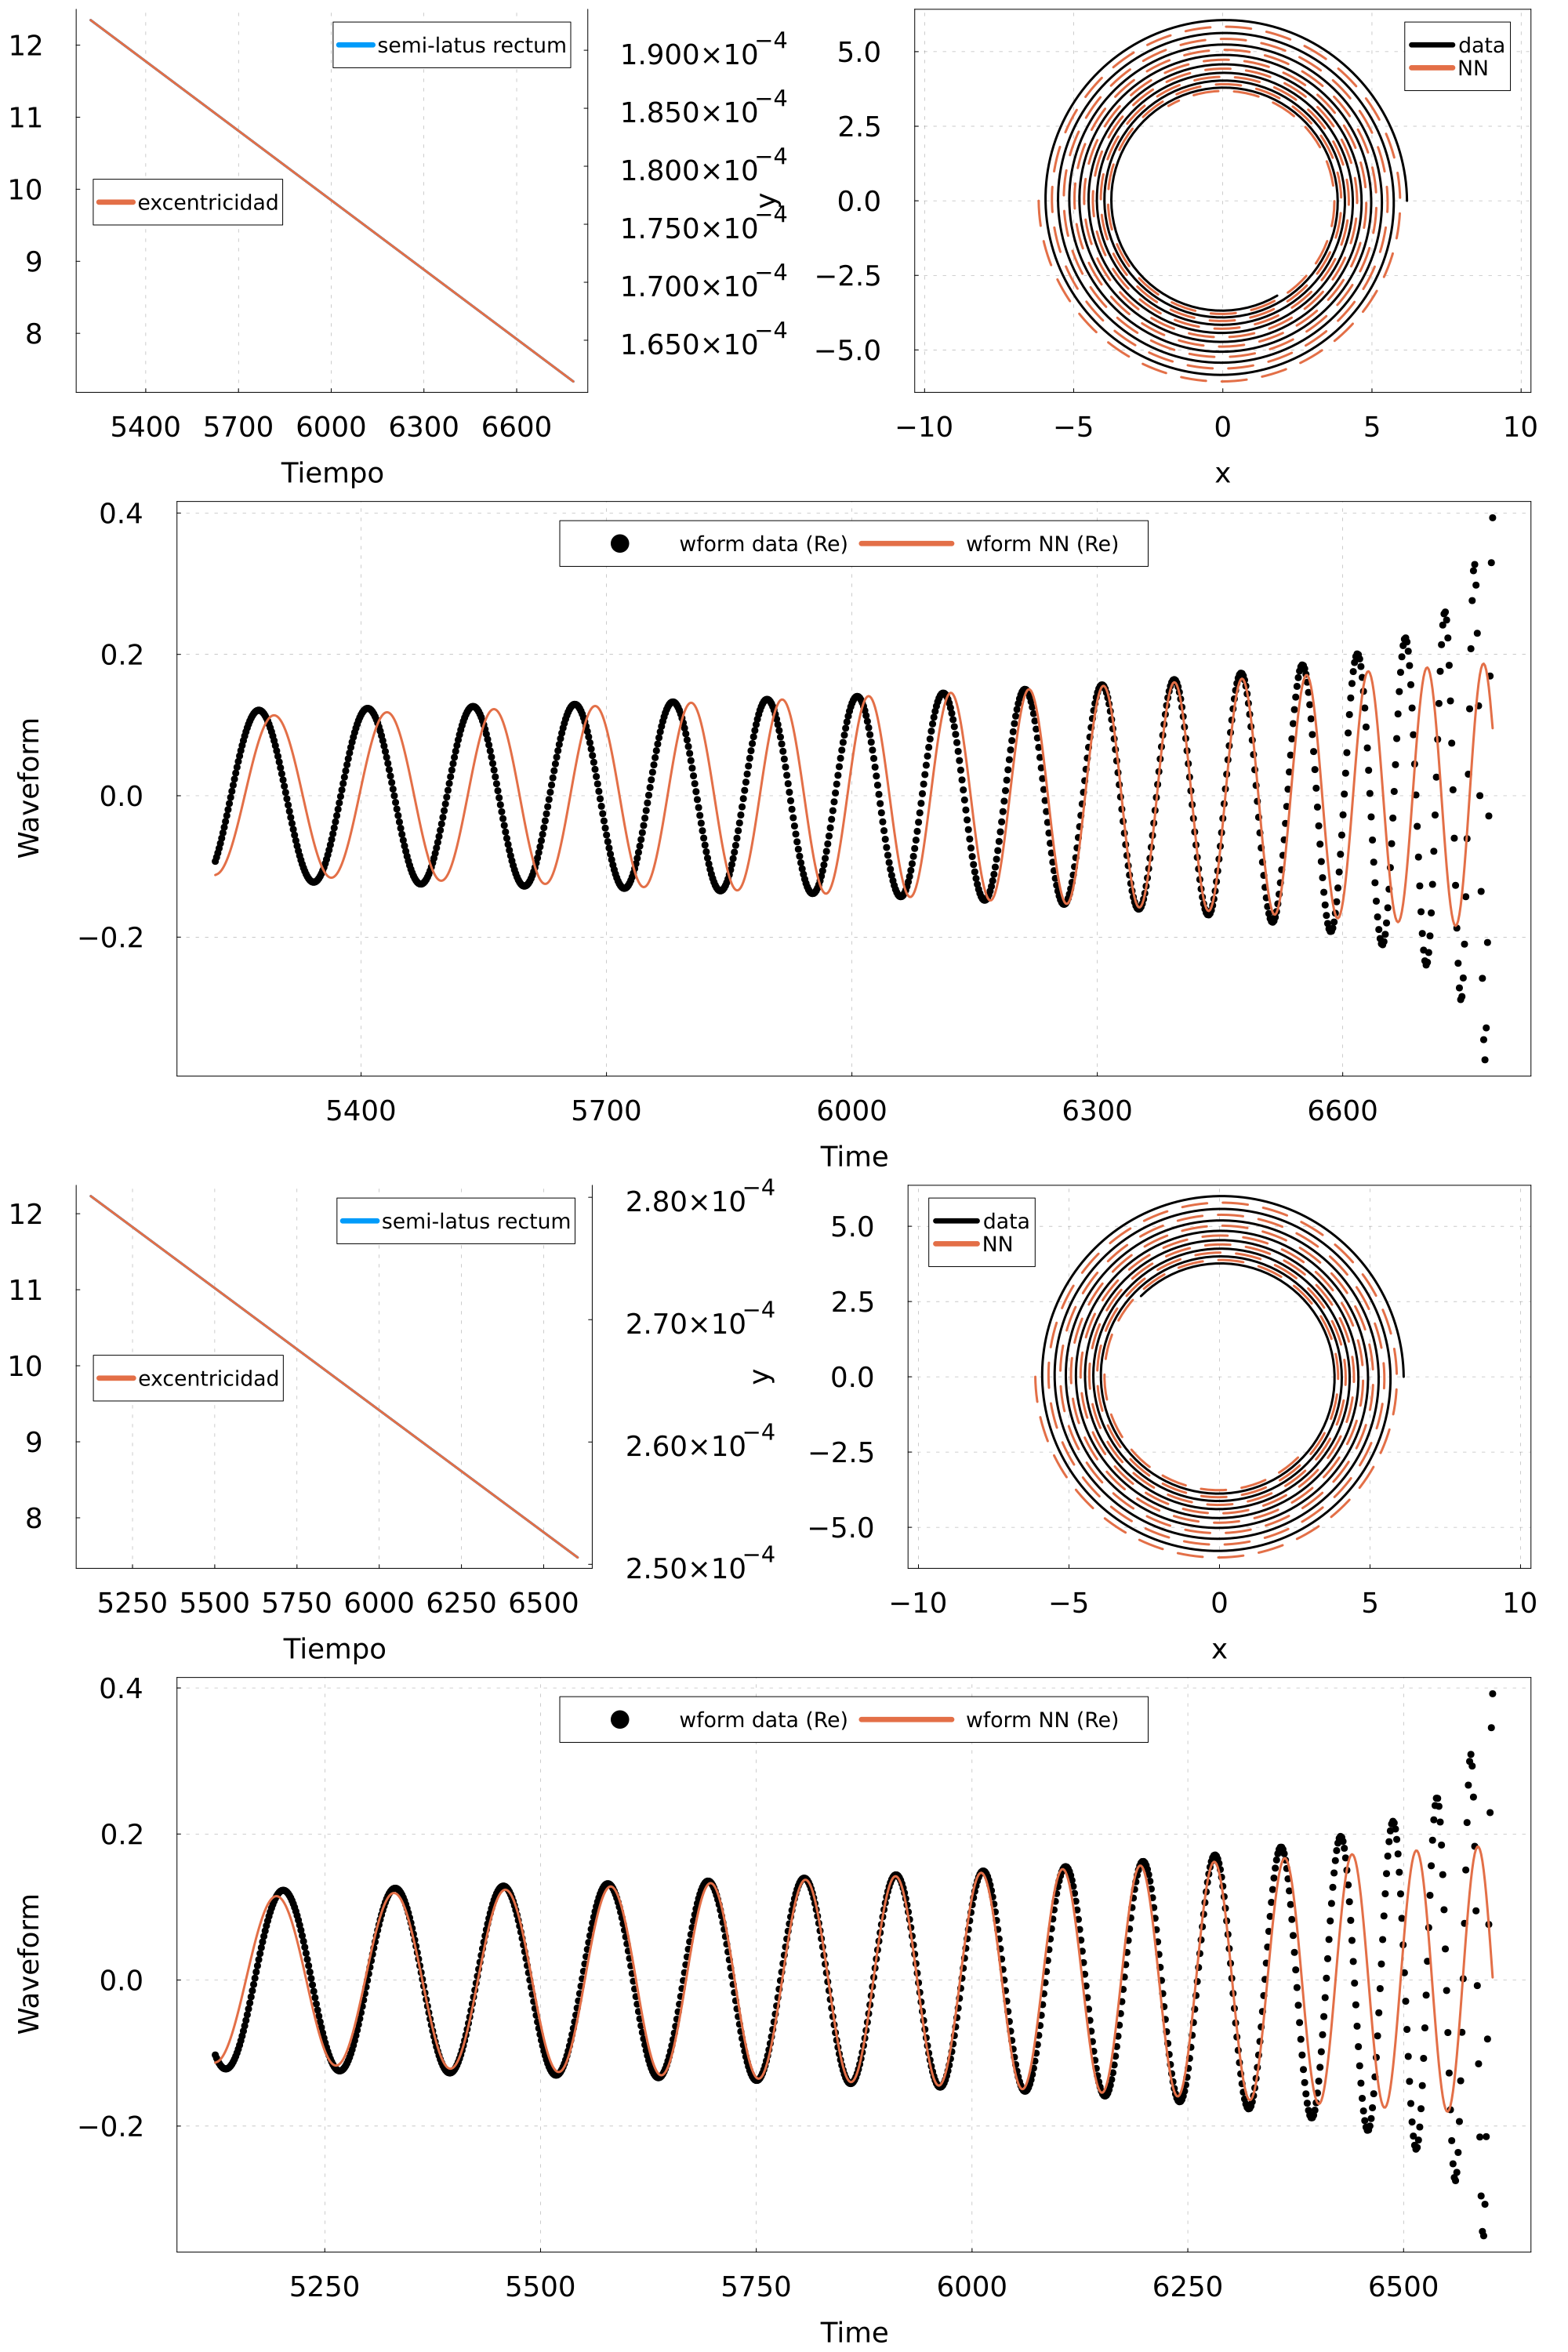

In [12]:
display(plt)

In [13]:
savefig(plt, predictions_dir*"plot.png")
savefig(plt, predictions_dir*"plot.pdf")

"/home/rubenbalbastre/Escritorio/TFM/code/01_project/data/output/case_2/schwarzschild/models/test_1_cos/predictions/plot.pdf"